# Summary

```Objective```

Test unaligned loss (minimum of surrounding)

```Methods```

todo

```Results```

todo

# Config

# Libs

In [4]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from misalign.data.IXI_datamodule import IXIDataModule
from misalign.draw import blend_and_transpose
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analysis

path exists for /home/kanghyun/misalign-benchmark/data/IXI/train/prepared_data_0_0.h5
path exists for /home/kanghyun/misalign-benchmark/data/IXI/val/prepared_data_0.0_0.0.h5
path exists for /home/kanghyun/misalign-benchmark/data/IXI/test/prepared_data_0.0_0.0.h5


torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


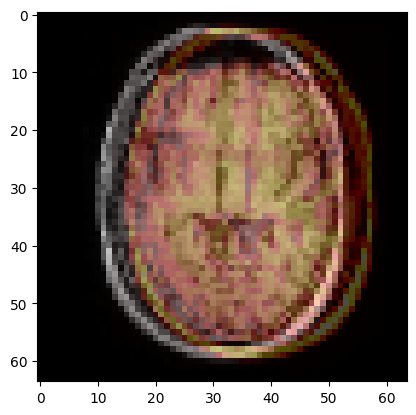

In [103]:
misalign_x = 0
misalign_y = 0

_ = IXIDataModule('/home/kanghyun/misalign-benchmark/data/IXI', batch_size=1, misalign_x=misalign_x, misalign_y=misalign_y)
_.prepare_data()
_.setup()
train_data = _.train_dataloader()

for a, b in train_data:
    print(a.shape, b.shape)
    break

im = F.interpolate(a, size=(64,64), mode='bilinear', align_corners=True)

im_shifted = torch.roll(im, shifts=5, dims=(-1))

blended_img = blend_and_transpose(im[0,0], im_shifted[0,0])
plt.imshow(blended_img)
plt.show()

In [ ]:
# original: im # size: (1,1,64,64)
# shifted: im_shifted : (1,1,64,64)

In [13]:
# original: im # size: (1,1,64,64)
# shifted: im_shifted : (1,1,64,64)
# How to calculate the loss L2 between these two images?

# first derive patch
im_patch = F.unfold(im, kernel_size=(12,12), padding=0, stride=5)
print('unfolded size (im):', im_patch.size())
im_shifted_patch = F.unfold(im_shifted, kernel_size=(12,12), padding=0, stride=1)
print('unfolded size (shifted):', im_shifted_patch.size())
print('')
# second calculate matmul product of im_patch and im_patch (im_patch.T @ im_patch)
im_square = torch.matmul(torch.transpose(im_patch, 1, 2), im_patch)
print('im_square size:', im_square.size())

im_shifted_square = torch.matmul(torch.transpose(im_shifted_patch, 1, 2), im_shifted_patch)
print('im_shifted_square size:', im_shifted_square.size())

im_im_shifted_correlation = torch.matmul(torch.transpose(im_shifted_patch, 1, 2), im_patch)
print('im_im_shifted_correlation size:', im_im_shifted_correlation.size())

# compute L2
dist = im_square + im_shifted_square - 2 * im_im_shifted_correlation
dist = torch.clamp(dist, min=float(0.0))
print('dist size:', dist.size())

# calc relative distance : what does this mean?
# from the code
epsilon = 1e-5
div = torch.min(dist, dim=2, keepdim=True)[0]

#relative_dist = cs_flow.calc_relative_distances()
#cs_flow.__calculate_CS(relative_dist)

unfolded size (im): torch.Size([1, 144, 2809])
unfolded size (shifted): torch.Size([1, 144, 2809])

im_square size: torch.Size([1, 2809, 2809])
im_shifted_square size: torch.Size([1, 2809, 2809])
im_im_shifted_correlation size: torch.Size([1, 2809, 2809])
dist size: torch.Size([1, 2809, 2809])


In [46]:
def compute_l2_distance(x, y):
    N, C, H, W = x.size()
    x_vec = x.view(N, C, -1)
    y_vec = y.view(N, C, -1)
    x_s = torch.sum(x_vec ** 2, dim=1, keepdim=True)
    y_s = torch.sum(y_vec ** 2, dim=1, keepdim=True)

    A = y_vec.transpose(1, 2) @ x_vec
    dist = y_s - 2 * A + x_s.transpose(1, 2)
    dist = dist.transpose(1, 2).reshape(N, H * W, H * W)
    dist = dist.clamp(min=0.)

    return dist

def compute_relative_distance(dist_raw):
    dist_min, _ = torch.min(dist_raw, dim=2, keepdim=True)
    dist_tilde = dist_raw / (dist_min + 1e-5)
    return dist_tilde

def compute_cx(dist_tilde, band_width):
    w = torch.exp((1 - dist_tilde) / band_width)  # Eq(3)
    cx = w / torch.sum(w, dim=2, keepdim=True)  # Eq(4)
    return cx

In [141]:
im_patch.shape

torch.Size([1, 441, 44, 44])

In [139]:
# im_patch: 1 x 441 x 44 x 44 (N x C X H x W)
im_patch_local = im_patch.unfold(2, 21, 1).unfold(3, 21, 1) # size : 1 x 441 x 24 x 24 x 21 x 21 (BS x C x H x W x k x k)
im_shifted_patch_local = im_shifted_patch.unfold(2, 21, 1).unfold(3,21,1)

print('patch_size:', im_patch_local.shape)

out = torch.einsum('bnchwk,bnchwk -> bnchw', im_patch_local, im_shifted_patch_local)

patch_size: torch.Size([1, 441, 24, 24, 21, 21])


In [135]:
im_patch = F.unfold(im, kernel_size=(21,21), padding=0, stride=1)
print('unfolded size (im):', im_patch.size())
im_shifted_patch = F.unfold(im_shifted, kernel_size=(21,21), padding=0, stride=1)
print('unfolded size (shifted):', im_shifted_patch.size())
print('')

im_patch = im_patch.view(1,im_patch.size()[1],int(im_patch.size()[-1]**0.5),int(im_patch.size()[-1]**0.5))
im_shifted_patch = im_shifted_patch.view(1,im_shifted_patch.size()[1],int(im_shifted_patch.size()[-1]**0.5),int(im_shifted_patch.size()[-1]**0.5))

print('unfolded and resized size (im_patch):', im_patch.size())
print('unfolded and resized size (im_shifted_patch):', im_shifted_patch.size())

dist_raw = compute_l2_distance(im_patch, im_shifted_patch)
dist_tilde = compute_relative_distance(dist_raw)

cx = compute_cx(dist_tilde, band_width=0.5)
cx = torch.mean(torch.max(cx, dim=1)[0], dim=1)  # Eq(1)
cx_loss = -torch.log(cx + 1e-5)  # Eq(5)

unfolded size (im): torch.Size([1, 441, 1936])
unfolded size (shifted): torch.Size([1, 441, 1936])

unfolded and resized size (im_patch): torch.Size([1, 441, 44, 44])
unfolded and resized size (im_shifted_patch): torch.Size([1, 441, 44, 44])


In [122]:
x0 = torch.diagonal(im_patch,dim1=-2,dim2=-1)
print(x0)

tensor([[[-1.0000, -1.0000, -1.0000,  ..., -0.1791, -0.3145, -0.4932],
         [-1.0000, -1.0000, -1.0000,  ..., -0.1978, -0.3835, -0.3809],
         [-1.0000, -1.0000, -1.0000,  ..., -0.2080, -0.3466, -0.2286],
         ...,
         [-0.8013, -0.7384, -0.6971,  ..., -1.0000, -1.0000, -1.0000],
         [-0.5025, -0.6934, -0.4237,  ..., -1.0000, -1.0000, -1.0000],
         [-0.4120, -0.6776, -0.4353,  ..., -1.0000, -1.0000, -1.0000]]])


In [126]:
x0 = torch.diagonal(im_shifted_patch, offset=5, dim1=-2,dim2=-1)
print(x0)
print(x0.shape)

tensor([[[-1.0000, -1.0000, -1.0000,  ..., -0.5366, -0.3339, -0.3839],
         [-1.0000, -1.0000, -1.0000,  ..., -0.4469, -0.3549, -0.3723],
         [-1.0000, -1.0000, -1.0000,  ..., -0.3228, -0.4196, -0.5978],
         ...,
         [-0.8013, -0.7384, -0.6971,  ..., -1.0000, -1.0000, -1.0000],
         [-0.5025, -0.6934, -0.4237,  ..., -1.0000, -1.0000, -1.0000],
         [-0.4120, -0.6776, -0.4353,  ..., -1.0000, -1.0000, -1.0000]]])
torch.Size([1, 441, 39])


In [118]:
cx = compute_cx(dist_tilde, band_width=0.5)
test, idx = torch.max(cx, dim=1)

In [119]:
print(idx[0,1000:1100])

tensor([ 696, 1313, 1287, 1287, 1154, 1154, 1154, 1154, 1154, 1154, 1287, 1154,
         220,  308, 1895,  660,  616, 1056,  969, 1058, 1059, 1016,  806,  507,
        1475,  956,  423,  423,  466,  817,  641, 1132, 1001,  736,  604,  601,
         471,  696, 1313, 1313, 1313, 1269, 1287,  785,  696, 1313, 1287, 1331,
        1154, 1154, 1154, 1154, 1287, 1287, 1287, 1154, 1760,  352,  221,  660,
        1895, 1056, 1101, 1058, 1059, 1060, 1061,  507, 1474,  956, 1434,  467,
         466,  465,  465, 1132, 1001,  736,  604,  560,  515,  740, 1313, 1005,
        1313,  521,  609,  785,  696, 1313, 1199, 1331, 1198, 1154, 1154, 1154,
        1287, 1287, 1287, 1154])


In [59]:
test.shape

torch.Size([1, 2809])

In [50]:
cx = compute_cx(dist_tilde, band_width=0.5)

cx

tensor([[[7.9174e-04, 7.9174e-04, 7.9174e-04,  ..., 0.0000e+00,
          1.2300e-35, 3.9549e-09],
         [7.9174e-04, 7.9174e-04, 7.9174e-04,  ..., 0.0000e+00,
          2.7490e-38, 3.9549e-09],
         [7.9174e-04, 7.9174e-04, 7.9174e-04,  ..., 0.0000e+00,
          1.2300e-35, 3.9549e-09],
         ...,
         [7.4794e-04, 7.4794e-04, 7.4794e-04,  ..., 7.4794e-04,
          7.4794e-04, 7.4794e-04],
         [7.6161e-04, 7.6161e-04, 7.6161e-04,  ..., 0.0000e+00,
          7.6161e-04, 7.6161e-04],
         [7.6569e-04, 7.6569e-04, 7.6569e-04,  ..., 0.0000e+00,
          2.3814e-30, 7.6569e-04]]])

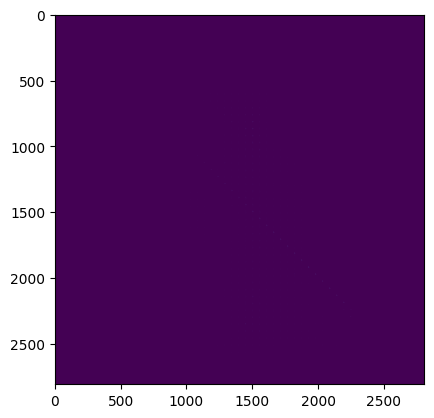

In [52]:
plt.imshow(cx[0].detach().numpy())

In [41]:
dist_min, _ = torch.min(dist_raw, dim=2, keepdim=True)

In [45]:
print(_[0,:200,0])

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11,  12,  12,
         12,  15,  11,  11,  11,  12,  20,  21,  22,  72,  23,  23,  21,  21,
         11,  11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11,  11,  11,
         11,  11,  11,  11,  11,  11,  11,   0,  20,  20,  20,  21,  21,  21,
         21,  23,  72,  73,  74,  76,  77, 127,  77,  76,  75,  73,  20,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  20,  20,  20,  20,  12,  11,
         11,  11,  11,  11,   0,  21,  21,  21,  22,  73,  73,  74,  75,  75,
         76, 128, 129, 130, 179, 130, 129,  77,  74,  21,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  21,  21,  22,  21,  21,  21,  20,  20,  20,
         12,   0,  20,  21,  22,  23,  75,  76,  77, 128, 130, 1

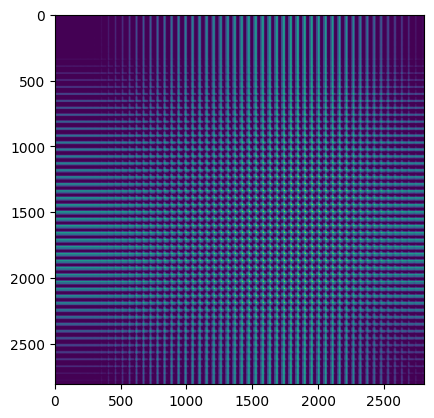

In [43]:
plt.imshow(dist_raw[0].detach().numpy())

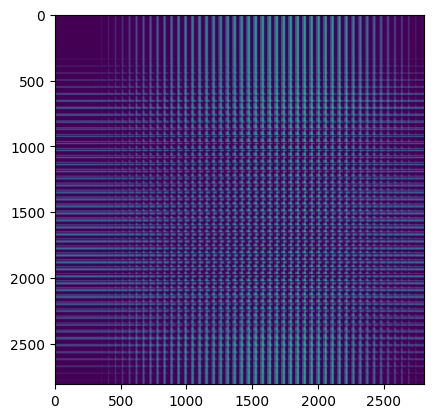

In [44]:
plt.imshow(dist_tilde[0].detach().numpy())

In [15]:
print(im_patch.shape, im_shifted_patch.shape)



torch.Size([1, 144, 2809]) torch.Size([1, 144, 2809])


In [ ]:
im_shifted_patch.shape

In [ ]:
im_im_shifted_correlation = torch.matmul(torch.transpose(im_shifted_patch[0], 0, 1), im_patch[0])
im_im_shifted_correlation2 = torch.matmul(torch.transpose(im_patch[0], 0, 1), im_shifted_patch[0])

torch.equal(im_im_shifted_correlation.T, im_im_shifted_correlation2)

In [ ]:
im_im_shifted_correlation2

In [ ]:
im_im_shifted_correlation

In [ ]:
test = torch.argmin(dist, dim=-1, keepdim=True)[0]

In [ ]:
print(test[:30])

In [12]:
dist[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(-0.5, 2808.5, 2808.5, -0.5)

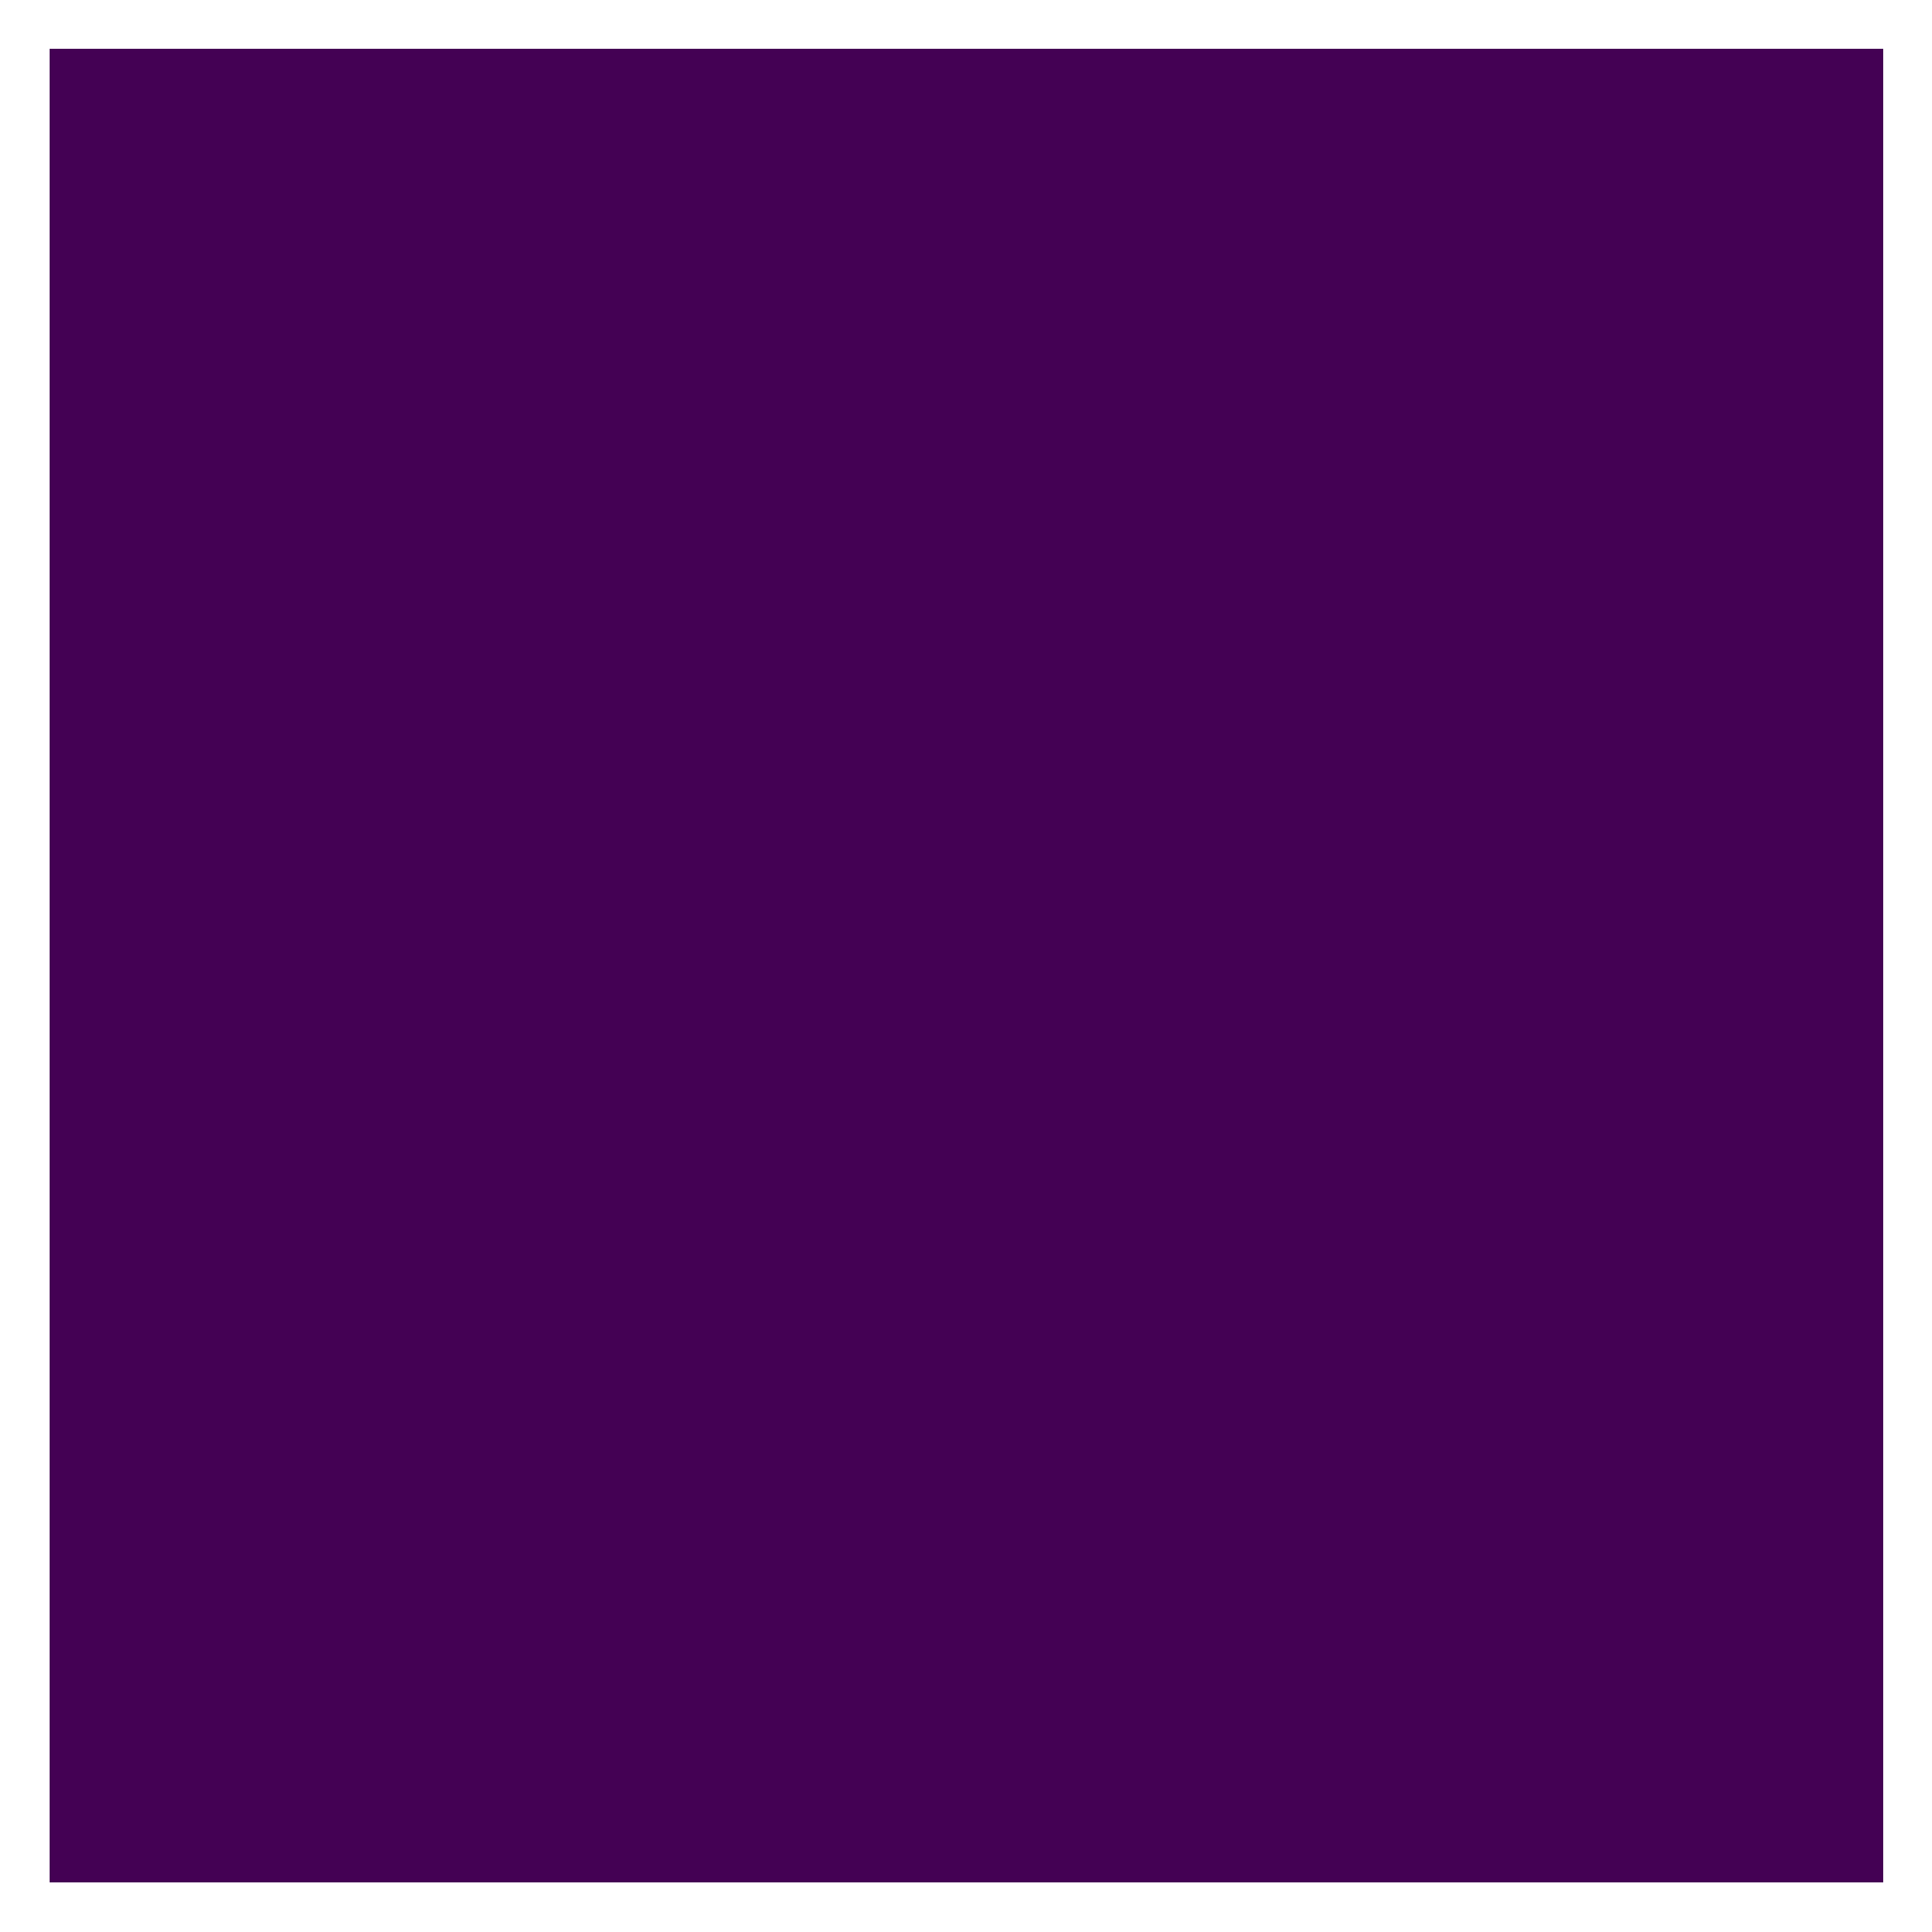

In [14]:
# Let's plot what dist looks like
plt.figure(dpi=600)
plt.imshow(dist[0].detach().numpy())
plt.axis('off')

In [ ]:
theta = torch.Tensor([[1, 0, 1], [0, 1, 0]]).unsqueeze(0)
print(theta.shape)
print(theta)